<a href="https://www.kaggle.com/code/muniramou/thesis-code?scriptVersionId=100998112" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14951 sha256=83eae5eb2d9e108385002dce6309f50ef98aabfc24e96917203cc6e2d24bc443
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown


In [2]:
%%bash
sudo apt-get install -y unzip

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-25ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 26 not upgraded.


In [3]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#DIRECTORY = r'C:\Users\Mamun\Documents\ML Data Analysis\Cats-Vs-Dog'
DIRECTORY = '../input/bangla/bangla'
CATEGORIES = ['aids', 'allergies','diabetes','diarrhea','drug_reaction']
print(DIRECTORY)
print(os.listdir(DIRECTORY))

../input/bangla/bangla
['aids', 'diabetes', 'drug_reaction', 'diarrhea', 'allergies']


In [5]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  21.6M      0  0:00:38  0:00:38 --:--:-- 21.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7469  100  7469    0     0  27765      0 --:--:-- --:--:-- --:--:-- 27662


In [6]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2022-07-16 16:57:07.946828: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
I0716 16:57:09.170840 139775541532480 builder_impl.py:781] Assets written to: text_module/assets


In [7]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

2022-07-16 16:57:09.699280: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-16 16:57:09.791209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
embedding_layer(['এলার্জি	', 'তৃষ্ণা_বৃদ্ধি_পাওয়া', 'স্পটিং_ প্রস্রাব', 'মাউথ_আলসার', 'ওজন_কমে_যাওয়া'])

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02064752,  0.00176777, -0.04030509, ...,  0.02241528,
         0.02390021,  0.00219203],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])>

In [9]:
file_paths = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    #print(path)
    for i, dir in enumerate(CATEGORIES):
      file_names = ["/".join([path, name]) for name in os.listdir(path)]
      file_paths += file_names
      labels += [i] * len(os.listdir(path))

print(file_paths)
print(labels)






['../input/bangla/bangla/aids/1.txt', '../input/bangla/bangla/aids/1.txt', '../input/bangla/bangla/aids/1.txt', '../input/bangla/bangla/aids/1.txt', '../input/bangla/bangla/aids/1.txt', '../input/bangla/bangla/allergies/1.txt', '../input/bangla/bangla/allergies/1.txt', '../input/bangla/bangla/allergies/1.txt', '../input/bangla/bangla/allergies/1.txt', '../input/bangla/bangla/allergies/1.txt', '../input/bangla/bangla/diabetes/1.txt', '../input/bangla/bangla/diabetes/1.txt', '../input/bangla/bangla/diabetes/1.txt', '../input/bangla/bangla/diabetes/1.txt', '../input/bangla/bangla/diabetes/1.txt', '../input/bangla/bangla/diarrhea/1.txt', '../input/bangla/bangla/diarrhea/1.txt', '../input/bangla/bangla/diarrhea/1.txt', '../input/bangla/bangla/diarrhea/1.txt', '../input/bangla/bangla/diarrhea/1.txt', '../input/bangla/bangla/drug_reaction/1.txt', '../input/bangla/bangla/drug_reaction/1.txt', '../input/bangla/bangla/drug_reaction/1.txt', '../input/bangla/bangla/drug_reaction/1.txt', '../input/

In [10]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)
print(train_size)

20


In [11]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [12]:
def make_datasets(train_size):
  batch_size = 5

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size] 
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [13]:
train_data, validation_data = make_datasets(train_size)

print(train_data)
print(validation_data)

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>
<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>


## Model

In [14]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [15]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## Training

In [16]:

history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5
4/4 [==============================] - 1s 95ms/step - loss: 1.6099 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/5
4/4 [==============================] - 0s 11ms/step - loss: 1.6095 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/5
4/4 [==============================] - 0s 11ms/step - loss: 1.6097 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 4/5
4/4 [==============================] - 0s 12ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 5/5
4/4 [==============================] - 0s 11ms/step - loss: 1.6095 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000


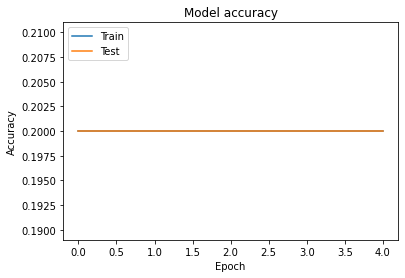

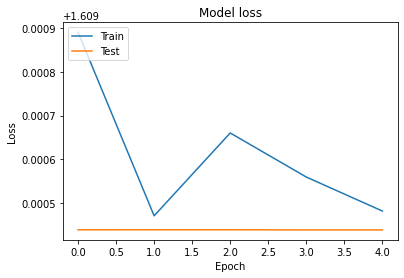

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
y_pred = model.predict(validation_data)

In [19]:
y_pred = np.argmax(y_pred, axis=1)

In [20]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ",sample.split("/")[4])
  print("Predicted Class: ", CATEGORIES[y_pred[i]])
  f.close()
  

মাত্রাতিরিক্ত_জ্বর,শরীরে র‍্যাশ,ক্লান্তি,মাউথ_আলসার	

True Class:  aids
Predicted Class:  aids
মাত্রাতিরিক্ত_জ্বর,শরীরে র‍্যাশ,ক্লান্তি,মাউথ_আলসার	

True Class:  aids
Predicted Class:  aids
মাত্রাতিরিক্ত_জ্বর,শরীরে র‍্যাশ,ক্লান্তি,মাউথ_আলসার	

True Class:  aids
Predicted Class:  aids


In [21]:
y_true = np.array(labels[train_size:])

In [22]:
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

               precision    recall  f1-score   support

         aids       0.20      1.00      0.33         1
    allergies       0.00      0.00      0.00         1
     diabetes       0.00      0.00      0.00         1
     diarrhea       0.00      0.00      0.00         1
drug_reaction       0.00      0.00      0.00         1

     accuracy                           0.20         5
    macro avg       0.04      0.20      0.07         5
 weighted avg       0.04      0.20      0.07         5



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
